# Instantiate the model and use it

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax
from jax import random, numpy as jnp
import flax

from paramperceptnet.models import PerceptNet
from paramperceptnet.configs import param_config

## Load a configuration

In [4]:
print(param_config)
model = PerceptNet(param_config)

A_GABOR: true
A_GDNSPATIOFREQORIENT: true
BATCH_SIZE: 64
CS_KERNEL_SIZE: 21
END_LR: 0.005
EPOCHS: 500
GABOR_KERNEL_SIZE: 31
GDNGAUSSIAN_KERNEL_SIZE: 11
GDN_CLIPPING: true
INITIAL_LR: 0.01
INIT_GABOR: true
INIT_JH: true
LEARNING_RATE: 0.003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
PEAK_LR: 0.04
SEED: 42
TRAIN_CS: false
TRAIN_GABOR: false
TRAIN_GDNCOLOR: false
TRAIN_GDNGAMMA: false
TRAIN_GDNGAUSSIAN: false
TRAIN_JH: false
TRAIN_ONLY_LAST_GDN: true
USE_BIAS: false
USE_GAMMA: true
WARMUP_EPOCHS: 15
ZERO_MEAN: true



## Instantiate the model

In [13]:
variables = model.init(random.PRNGKey(42), jnp.ones((1, 32, 32, 3)))
state, params = flax.core.pop(variables, "params")
shapes = jax.tree_util.tree_map(lambda x: x.shape, variables)
print(shapes)

FrozenDict({
    params: {
        CenterSurroundLogSigmaK_0: {
            A: (9,),
            K: (9,),
            logsigma: (9,),
        },
        Color: {
            kernel: (1, 1, 3, 3),
        },
        GDNGamma_0: {
            bias: (1,),
            kernel: (1,),
        },
        GDNGaussian_0: {
            GaussianLayerGamma_0: {
                A: (3,),
                bias: (3,),
                gamma: (3,),
            },
        },
        GDNSpatioChromaFreqOrient_0: {
            B: (128,),
            ChromaFreqOrientGaussianGamma_0: {
                H_cc: (3, 3),
                gamma_f_a: (4,),
                gamma_f_d: (2,),
                gamma_f_t: (2,),
                gamma_theta_a: (8,),
                gamma_theta_d: (8,),
                gamma_theta_t: (8,),
            },
            GaussianLayerGamma_0: {
                A: (128,),
                gamma: (128,),
            },
            bias: (128,),
        },
        GDN_0: {
            Co

At initialization, only the parameters are initialized (not the parametric filters), so we have to force them to initialize by calling the model on a sample image with the parameter `train=True`:

In [27]:
pred, state = model.apply({"params": params, **state}, jnp.ones((1,32,32,3)), train=True, mutable=list(state.keys()))

## Load an image and pass it through the model

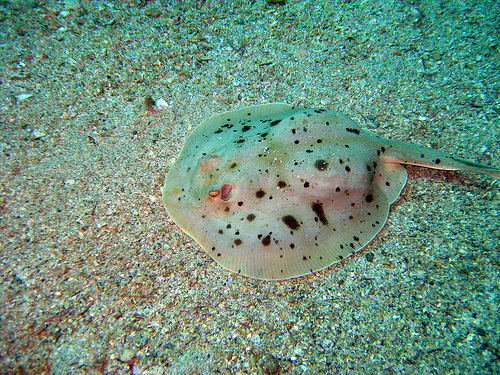

In [8]:
import requests
from PIL import Image
from io import BytesIO

# Replace with your image URL
img_url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01498041_stingray.JPEG?raw=true"

# Fetch the image
response = requests.get(img_url, stream=True)
response.raw.decode_content = True

# Open the image using PIL
img_ = Image.open(BytesIO(response.content))
img_

In [17]:
img = jnp.array(img_)/255.0
img.shape, img.min(), img.max()

((375, 500, 3), Array(0., dtype=float32), Array(1., dtype=float32))

In [28]:
pred = model.apply({"params": params, **state}, img[None,...])
pred.shape

(1, 93, 125, 128)

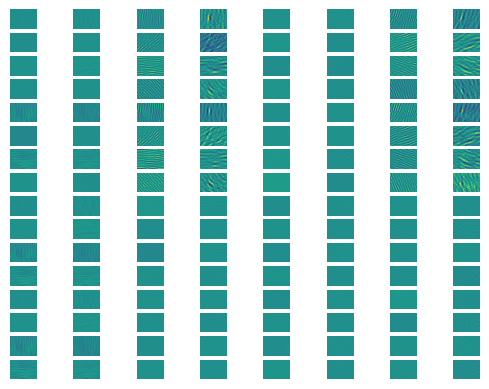

In [29]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(16,8)
for i, ax in enumerate(axes.ravel()):
    ax.imshow(pred[0,...,i])
    ax.axis("off")
plt.show()